# Additional figures of "Top-down connection in hierarchical sparse coding" for the ATT database
https://arxiv.org/abs/2002.00892

In [1]:
from SPC_2L.DataTools import DataBase, to_img, show
import pickle
from SPC_2L.Network import LayerPC, Network
from SPC_2L.Coding import ML_FISTA, ML_Lasso
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid, save_image
import torch
from torchvision.transforms import ToTensor,Compose
from SPC_2L.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
from torch.utils.data import DataLoader

In [2]:
## Tools, parameters and database

In [3]:
def to_img(x):
    val_max = x.abs().max(-1, keepdim=True)[0].max(-2, keepdim=True)[0].expand_as(x)
    x += val_max
    x /= 2 * val_max
    x.clamp(0, 1)
    return x

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    return plt

In [4]:
data_path = '../DataSet/Face_DataBase/Face_DataBase_testing'

LCN_params = {'kernel_size':9,'sigma':0.5} # Local contrast normalization parameters

mask_params={'n': 10} # mask parameters

whitening_params={'f_0':0.5,'n':2} # Whitening parameters

Data_load_param = { 'batch_size': 20,
                    'gray_scale': True,
                    'do_LCN': True,
                    'LCN_params': LCN_params,
                    'do_mask': True,
                    'mask_params': mask_params,
                    'do_whitening': True,
                    'whitening_params': whitening_params,
                    'do_z_score': True,
                    'return_idx': False
                  }

Facedata = DataBase('from_ImageFolder', data_path, img_size=(112,92),**Data_load_param, shuffle=True)
nb_image=100

## Fig 15 a) & c)

In [5]:
model_name_list = ['Savings/ATT/'+'ATT_[0.5,1.0]_b=1.pkl']

In [6]:
all_sparsity = torch.zeros(nb_image,len(model_name_list),2)
all_activity = torch.zeros(len(model_name_list),2)
all_histo = [None]*len(model_name_list)
for idx_model, model_name in enumerate(model_name_list) : 
    k=0
    with open(model_name, 'rb') as file:
        out = pickle.load(file)
    Net = out['Net']
    Loss = out['Loss']
    Pursuit = out['Pursuit']
    histo = [0,0]
    for idx_batch, data in enumerate(Facedata.data):
        batch = data[0].cuda()
        gamma, it, Loss_G, delta = Pursuit.coding(batch)

        for i in range(Net.nb_layers):
            nb_null = (gamma[i]!=0).float().view(gamma[i].size(0),-1).sum(-1)
            volume = gamma[i].size(1)*gamma[i].size(2)*gamma[i].size(3)
            all_sparsity[k:k+batch.size(0),idx_model,i] = (1-nb_null/volume)*100
            freq = (gamma[i]!=0).view(batch.size(0),gamma[i].size(1),-1)
            freq = freq.sum(-1).sum(0)
            histo[i] += freq 
        k+=batch.size(0)
        if k >= nb_image:
            break

    all_histo[idx_model] = histo

Exp = {'model_name': model_name_list,
        'sparsity' : all_sparsity,
        'histo':all_histo}

Dico Layer 1 with feedback


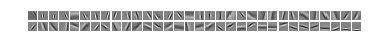

Dico Layer 2 with feedback


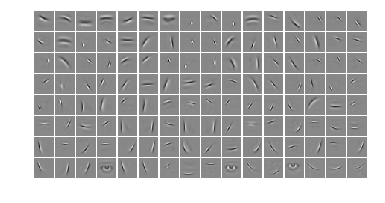

In [7]:
save_fig = True
all_histo = Exp['histo']
with open(model_name_list[0], 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
    
## FIRST LAYER DICTIONARIES
idx_model=0
idx_layer=0
position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

fig = plt.figure()
sorted_histo, arg_sorted = torch.sort(inter, descending=True)

grid_param = {'padding':1, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':32}
 
img = make_grid(Net.layers[0].dico[arg_sorted,:,:,:],**grid_param)
plot_L1 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig16/SD_ATT_2LSPC_L1_sorted.pdf')

print('Dico Layer 1 with feedback')
plot_L1.show()
    
## SECOND LAYER DICTIONARIES
idx_layer=1

position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

sorted_histo, arg_sorted = torch.sort(inter, descending=True)

fig = plt.figure()

grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':16}
img = make_grid(Net.project_dico(1)[arg_sorted],**grid_param)
plot_L2 = show(img.cpu())

if save_fig == True:
    save_image(img,'Savings/Fig/Fig16/SD_ATT_2LSPC_L2_sorted.pdf')
print('Dico Layer 2 with feedback')
plot_L2.show()

## Fig 15 b) & d)

In [8]:
model_name_list = ['Savings/ATT/'+'ATT_[0.5,1.0]_b=0.pkl']

In [9]:
all_sparsity = torch.zeros(nb_image,len(model_name_list),2)
all_activity = torch.zeros(len(model_name_list),2)
all_histo = [None]*len(model_name_list)
for idx_model, model_name in enumerate(model_name_list) : 
    k=0
    with open(model_name, 'rb') as file:
        out = pickle.load(file)
    Net = out['Net']
    Loss = out['Loss']
    Pursuit = out['Pursuit']
    histo = [0,0]

    for idx_batch, data in enumerate(Facedata.data):
        batch = data[0].cuda()
        gamma, it, Loss_G, delta = Pursuit.coding(batch)

        for i in range(Net.nb_layers):
            nb_null = (gamma[i]!=0).float().view(gamma[i].size(0),-1).sum(-1)
            volume = gamma[i].size(1)*gamma[i].size(2)*gamma[i].size(3)
            all_sparsity[k:k+batch.size(0),idx_model,i] = (1-nb_null/volume)*100
            freq = (gamma[i]!=0).view(batch.size(0),gamma[i].size(1),-1)
            freq = freq.sum(-1).sum(0)
            histo[i] += freq 
        k+=batch.size(0)
        if k >= nb_image:
            break

    all_histo[idx_model] = histo

Exp = {'model_name': model_name_list,
        'sparsity' : all_sparsity,
        'histo':all_histo}

Dico Layer 1 without feedback


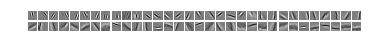

Dico Layer 2 without feedback


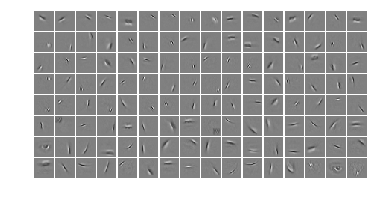

In [10]:
save_fig = True
all_histo = Exp['histo']

with open(model_name_list[0], 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
    
    
## FIRST LAYER DICTIONARIES
idx_model=0
idx_layer=0
position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

fig = plt.figure()
sorted_histo, arg_sorted = torch.sort(inter, descending=True)

grid_param = {'padding':1, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':32}
img = make_grid(Net.layers[0].dico[arg_sorted,:,:,:],**grid_param)
plot_L1 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig16/SD_STL_HiLa_L1_sorted.pdf')

print('Dico Layer 1 without feedback')
plot_L1.show()
    
## SECOND LAYER DICTIONARIES
idx_layer=1
position = torch.arange(all_histo[idx_model][idx_layer].size(0))
inter = all_histo[idx_model][idx_layer].float()/all_histo[idx_model][idx_layer].sum()

sorted_histo, arg_sorted = torch.sort(inter, descending=True)

fig = plt.figure()

grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':16}
img = make_grid(Net.project_dico(1)[arg_sorted],**grid_param)
plot_L2 = show(img.cpu())

if save_fig == True:
    save_image(img,'Savings/Fig/Fig16/SD_STL_HiLa_L2_sorted.pdf')
print('Dico Layer 2 without feedback')
plot_L2.show()